<a href="https://colab.research.google.com/github/mostafa-ja/Transformers/blob/main/Fine_Tune_ViT_for_Image_Classification_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://huggingface.co/blog/fine-tune-vit)

In [1]:
!pip install datasets transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.3 MB/s eta 0:00:00


# Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the beans dataset, which is a collection of pictures of healthy and unhealthy bean leaves. 
[link text](https://huggingface.co/datasets/beans)

In [2]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

Let's take a look at the 400th example from the 'train' split from the beans dataset. You'll notice each example from the dataset has 3 features:

image: A PIL Image

image_file_path: The str path to the image file that was loaded as image

labels: A datasets.ClassLabel feature, which is an integer representation of the label. (Later you'll see how to get the string class names, don't worry!)

In [3]:
ex = ds['train'][400]
ex

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/bean_rust/bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F5BA3003400>,
 'labels': 1}

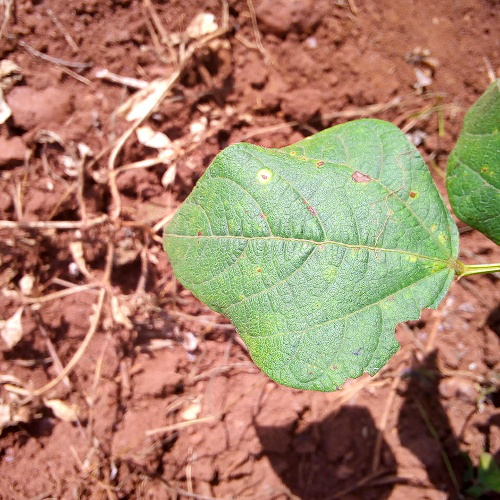

In [4]:
image = ex['image']
image

Since the 'labels' feature of this dataset is a datasets.features.ClassLabel, we can use it to look up the corresponding name for this example's label ID.

First, let's access the feature definition for the 'labels'.

In [58]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

Now, let's print out the class label for our example. You can do that by using the int2str function of ClassLabel, which, as the name implies, allows to pass the integer representation of the class to look up the string label.

In [57]:
ex['labels']

1

In [6]:
labels.int2str(ex['labels'])


'bean_rust'

Let's write a function that'll display a grid of examples from each class to get a better idea of what you're working with.

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

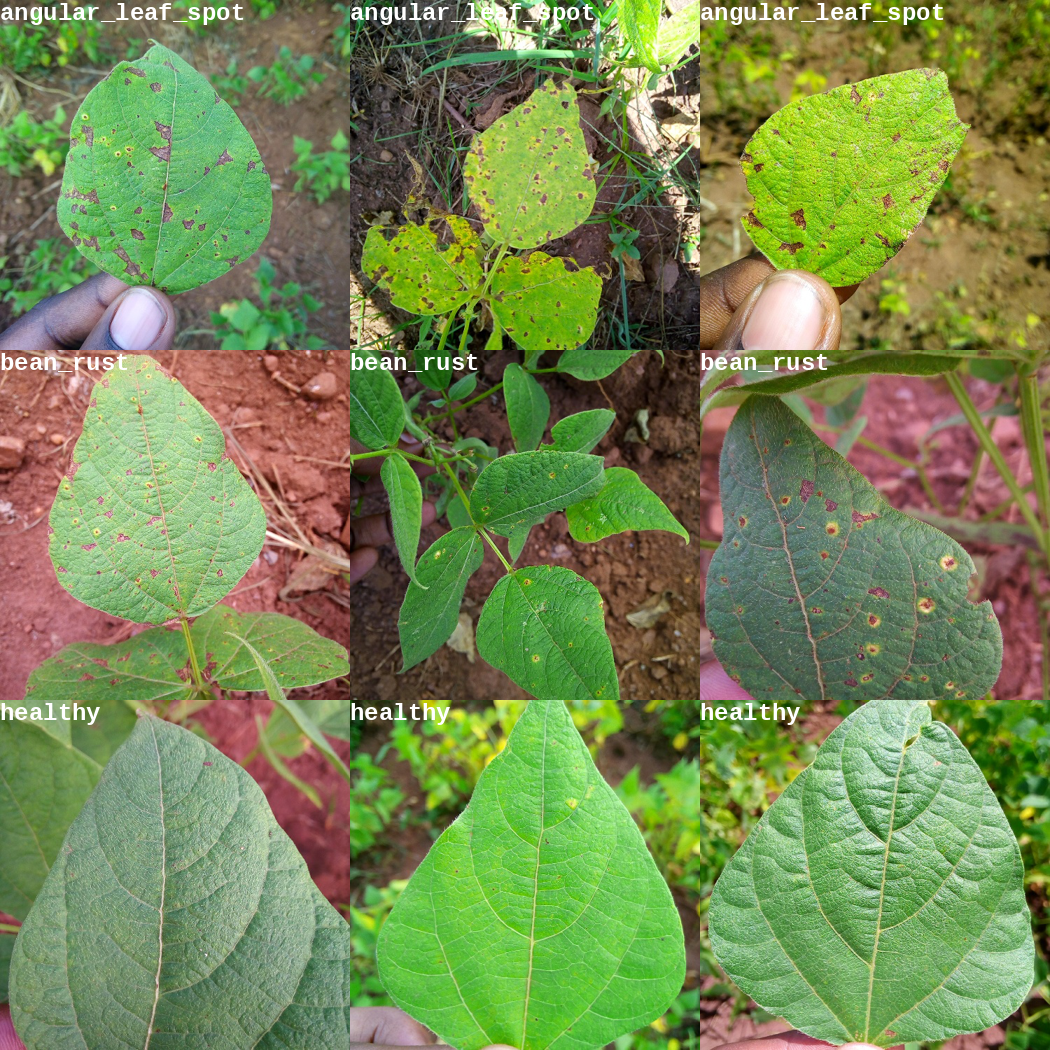

In [7]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)


# Loading ViT Feature Extractor

To make sure we apply the correct transformations, we will use a ViTFeatureExtractor initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the google/vit-base-patch16-224-in21k model, so let's load its feature extractor from the Hugging Face Hub.

In [8]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

look diffrence with a diffrent model

In [9]:
ViTFeatureExtractor.from_pretrained('facebook/vit-mae-base')

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model.

You get a NumPy array by default, but if you add the return_tensors='pt' argument, you'll get back torch tensors instead.

In [10]:
image = ds['train'][400]['image']
feature_extractor(image, return_tensors='pt')


{'pixel_values': tensor([[[[ 0.7882,  0.6706,  0.7098,  ..., -0.1922, -0.1294, -0.1765],
          [ 0.7020,  0.6000,  0.6863,  ..., -0.2863, -0.1608, -0.1608],
          [ 0.4824,  0.4039,  0.4667,  ..., -0.1922, -0.0196,  0.0275],
          ...,
          [ 0.3804,  0.5294,  0.4824,  ..., -0.8275, -0.8196, -0.8039],
          [ 0.0902,  0.3725,  0.3804,  ..., -0.8667, -0.8431, -0.8510],
          [-0.0510,  0.2784,  0.3176,  ..., -0.8588, -0.8275, -0.8275]],

         [[ 0.4902,  0.3490,  0.3804,  ..., -0.6078, -0.5373, -0.5843],
          [ 0.3569,  0.2000,  0.3176,  ..., -0.7176, -0.6000, -0.5922],
          [ 0.0431, -0.0902,  0.0510,  ..., -0.6392, -0.4745, -0.4275],
          ...,
          [-0.2235, -0.0510, -0.0902,  ..., -0.9765, -0.9608, -0.9373],
          [-0.5059, -0.2078, -0.1922,  ..., -0.9922, -0.9922, -1.0000],
          [-0.6471, -0.3020, -0.2471,  ..., -0.9843, -0.9765, -0.9843]],

         [[ 0.4353,  0.2706,  0.3098,  ..., -0.7176, -0.6392, -0.6863],
          [ 0

In [11]:
feature_extractor(image, return_tensors='pt')['pixel_values'].shape

torch.Size([1, 3, 224, 224])

# Processing the Dataset

Now that you know how to read images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [12]:
a =feature_extractor(ds['train'][400]['image'], return_tensors='pt')
a['labels'] = ds['train'][400]['labels']
a

{'pixel_values': tensor([[[[ 0.7882,  0.6706,  0.7098,  ..., -0.1922, -0.1294, -0.1765],
          [ 0.7020,  0.6000,  0.6863,  ..., -0.2863, -0.1608, -0.1608],
          [ 0.4824,  0.4039,  0.4667,  ..., -0.1922, -0.0196,  0.0275],
          ...,
          [ 0.3804,  0.5294,  0.4824,  ..., -0.8275, -0.8196, -0.8039],
          [ 0.0902,  0.3725,  0.3804,  ..., -0.8667, -0.8431, -0.8510],
          [-0.0510,  0.2784,  0.3176,  ..., -0.8588, -0.8275, -0.8275]],

         [[ 0.4902,  0.3490,  0.3804,  ..., -0.6078, -0.5373, -0.5843],
          [ 0.3569,  0.2000,  0.3176,  ..., -0.7176, -0.6000, -0.5922],
          [ 0.0431, -0.0902,  0.0510,  ..., -0.6392, -0.4745, -0.4275],
          ...,
          [-0.2235, -0.0510, -0.0902,  ..., -0.9765, -0.9608, -0.9373],
          [-0.5059, -0.2078, -0.1922,  ..., -0.9922, -0.9922, -1.0000],
          [-0.6471, -0.3020, -0.2471,  ..., -0.9843, -0.9765, -0.9843]],

         [[ 0.4353,  0.2706,  0.3098,  ..., -0.7176, -0.6392, -0.6863],
          [ 0

In [13]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [14]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

While you could call ds.map and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, you can apply a transform to the dataset. Transforms are only applied to examples as you index them.

First, though, you'll need to update the last function to accept a batch of data, as that's what ds.with_transform expects.

In [15]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs


  0%|          | 0/3 [00:00<?, ?it/s]

You can directly apply this to the dataset using ds.with_transform(transform).

In [16]:
prepared_ds = ds.with_transform(transform)


Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices, as shown below)

he resulting pixel_values tensor will have shape (2, 3, 224, 224).

In [17]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

In [18]:
prepared_ds['train'][0:2]['pixel_values'].shape

torch.Size([2, 3, 224, 224])

# Training and Evaluation

This blog post uses 🤗's Trainer, but that'll require us to do a few things first:

Define a collate function.

Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. You should define a compute_metrics function accordingly.

Load a pretrained checkpoint. You need to load a pretrained checkpoint and configure it correctly for training.

Define the training configuration.

After fine-tuning the model, you will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify the images.

# Define our data collator
Batches are coming in as lists of dicts, so you can just unpack + stack those into batch tensors.

Since the collate_fn will return a batch dict, you can **unpack the inputs to the model later.

In [19]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


# Define an evaluation metric

The accuracy metric from datasets can easily be used to compare the predictions with the labels. Below, you can see how to use it within a compute_metrics function that will be used by the Trainer.

[link text](https://huggingface.co/spaces/evaluate-metric/accuracy)

In [20]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


<ipython-input-20-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Let's load the pretrained model. We'll add num_labels on init so the model creates a classification head with the right number of units. We'll also include the id2label and label2id mappings to have human-readable labels in the Hub widget (if you choose to push_to_hub).

In [21]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The last thing needed before that is to set up the training configuration by defining TrainingArguments.

Most of these are pretty self-explanatory, but one that is quite important here is remove_unused_columns=False. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set remove_unused_columns=False.

[link text](https://huggingface.co/docs/transformers/v4.13.0/en/performance)

```
Floating Data Types
Here are the commonly used floating point data types choice of which impacts both memory usage and throughput:

fp32 (float32)
fp16 (float16)
bf16 (bfloat16)
tf32 (CUDA internal data type)
Here is a diagram that shows how these data types correlate to each other.

data types

(source: NVIDIA Blog)

While fp16 and fp32 have been around for quite some time, bf16 and tf32 are only available on the Ampere architecture GPUS. TPUs support bf16 as well.

fp16
AMP = Automatic Mixed Precision

If we look at what’s happening with FP16 training (mixed precision) we have:

the model has two copies in memory: one in half-precision for the forward/backward computations and one in full precision - no memory saved here
the forward activations saved for gradient computation are in half-precision - memory is saved here
the gradients are computed in half-precision but converted to full-precision for the update, no saving there
the optimizer states are in full precision as all the updates are done in full-precision
So the savings only happen for the forward activations saved for the backward computation, and there is a slight overhead because the model weights are stored both in half- and full-precision.

In 🤗 Transformers fp16 mixed precision is enabled by passing --fp16 to the 🤗 Trainer.
```



In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


Now, all instances can be passed to Trainer and we are ready to start training!

In [24]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)


# Train 🚀


In [25]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1365
  train_runtime            =  0:01:59.86
  train_samples_per_second =      34.506
  train_steps_per_second   =       2.169


# Evaluate 📊

In [26]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0166
  eval_runtime            = 0:00:02.13
  eval_samples_per_second =     62.173
  eval_steps_per_second   =      7.947


you can make predictions with the pipeline abstraction

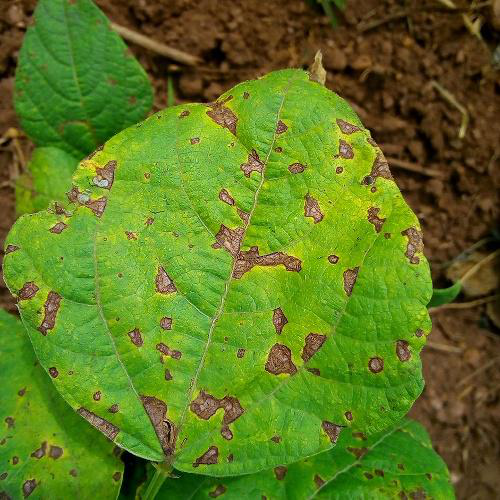

In [37]:
import requests
from PIL import Image



# Get example image from repo
url = 'https://huggingface.co/nateraw/vit-base-beans/resolve/main/angular_leaf_spot.jpeg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [35]:
x = feature_extractor(image, return_tensors='pt')['pixel_values'].to('cuda')
model(x)

ImageClassifierOutput(loss=None, logits=tensor([[ 3.1981, -1.8636, -1.7578]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [42]:
a = model(x)
a

ImageClassifierOutput(loss=None, logits=tensor([[ 3.1981, -1.8636, -1.7578]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [47]:
y = a.logits.detach().to('cpu')

In [62]:
predictions=np.argmax(y, axis=1)
predictions

tensor([0])

In [59]:
abels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [61]:
labels.int2str(predictions)

'angular_leaf_spot'